In [2]:
from PIL import Image
from tensorflow.keras.preprocessing import image as image_
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

model = load_model('my_model_softmax.h5')
model.load_weights('./weights/my_weights_softmax')
model.summary()

2021-12-16 13:16:19.293310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-16 13:16:19.294347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/franel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-16 13:16:19.294375: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 13:16:19.294403: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (latitude-5400-02): /proc/driver/nvidia/version does not exist


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 115, 115, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [4]:
labels = ['cat', 'dog']

In [5]:
def ablation_cam(model, image, layer_name, cat_class_index=None):
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_div = image_array / 255
    
    # Get gradients for the class on the last layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image_div])) #get activations maps + predictions from last conv layer
        output = conv_outputs[0] #activations maps from last conv layer
        
    weigths = np.zeros(model.get_layer(layer_name).get_weights()[1].shape)
    
    if cat_class_index is None:
        cat_class_index = np.argmax(model.predict(np.array([image_div])), axis=-1)[0]
        y_classe = np.max(model.predict(np.array([image_div])))
    else:
        y_classe = model.predict(np.array([image_div]))[0][cat_class_index]
        
    print('----------------------------------------------------')
    print('Affichage des heatmaps pour la classe ', labels[cat_class_index])
    print('----------------------------------------------------')
    print('')
        
    # Get weigth for each map
    all_weigths = model.get_layer(layer_name).get_weights().copy()
    zero_weigth = all_weigths[0][:, :, :, 0] * 0
    weigth_local = [np.zeros(all_weigths[0].shape)]
    weigth_local.append(np.zeros(all_weigths[1].shape))
    for i in range(weigths.shape[0]):
        weigth_local[0] = all_weigths[0].copy()
        weigth_local[0][:, :, :, i] = zero_weigth
        model.get_layer(layer_name).set_weights(weigth_local)
        y_k = model.predict(np.array([image_div]))[0][cat_class_index] # Predict
        weigths[i] = (y_classe - y_k) / y_classe
        model.get_layer(layer_name).set_weights(all_weigths)
        
    random = np.random.randint(output.shape[2], size=5)
    random2 = np.random.randint(output.shape[2], size=5)
    
    print('HEATMAP WITH WEIGTH AFTER TRAINING')
    print('----------------------------------')
    
    # Get 5 randoms MAPs
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random):
        ax = plt.subplot(1, 5, k + 1)
        map_ = np.maximum(output[:, :, compt], 0.0)
        map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random2):
        ax = plt.subplot(1, 5, k + 1)
        map_ = np.maximum(output[:, :, compt], 0.0)
        map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
                
    plt.figure(figsize=(16, 16))    
    
    # Concatenate all futeares maps
    output_mean = np.mean([output[:, :, i] for i in range(output.shape[2])], axis=0)
    output_mean = np.maximum(output_mean, 0.0)
        
    # Get mask
    output_mean_mask = np.zeros(output.shape[0: 2], dtype = np.float32)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output_mean[i][j] < np.mean(output_mean[:, :]):
                output_mean_mask[i][j] = 255
            else:
                output_mean_mask[i][j] = 0
    
    # Plot Features MAPs means for weigth
    ax = plt.subplot(1, 3, 1)
    output_mean = cv.resize(output_mean, (224, 224))
    plt.imshow(output_mean)
    plt.title('Features MAPs means')
    plt.axis("off")
    
    # Plot output with weigth map
    heatmap_weigth = (output_mean - output_mean.min()) / (output_mean.max() - output_mean.min())
    output_mean = cv.applyColorMap(np.uint8(255*heatmap_weigth), cv.COLORMAP_JET)
    output_image_weigth = cv.addWeighted(image_array.astype('uint8'), 0.5, output_mean, 0.5, 0)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(output_image_weigth)
    plt.axis("off")
    
    # Plot mask with weigth map
    ax = plt.subplot(1, 3, 3)
    mask_weigth = image_array.astype('uint8')
    output_mean_mask = cv.resize(output_mean_mask, (224, 224))
    for i in range(mask_weigth.shape[0]):
        for j in range(mask_weigth.shape[1]):
            if output_mean_mask[i][j] > 0:
                mask_weigth[i, j, 0] = 0
                mask_weigth[i, j, 1] = 0
                mask_weigth[i, j, 2] = 0
    
    plt.imshow(mask_weigth)
    plt.axis("off")
    plt.show()
        
    print('ABLATION-CAM')
    print('------------------------------------')
    
    ablations_map = weigths * output
    
    # Get 5 randoms MAPs
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random):
        ax = plt.subplot(1, 5, k + 1)
        map_ = np.maximum(ablations_map[:, :, compt], 0.0)
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt) + '\n (' + str(weigths[compt]) + ')')
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random2):
        ax = plt.subplot(1, 5, k + 1)
        map_ = np.maximum(ablations_map[:, :, compt], 0.0)
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt) + '\n (' + str(weigths[compt]) + ')')
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))    
    
    # Concatenate all futeares maps
    ablations_cam = np.sum(ablations_map, axis=(2))
    ablations_cam = np.maximum(ablations_cam, 0) # Apply ReLu
        
    # Get mask
    ablation_mask = np.zeros(ablations_map.shape[0: 2], dtype = np.float32)
    for i in range(ablations_map.shape[0]):
        for j in range(ablations_map.shape[1]):
            if ablations_cam[i][j] < np.mean(ablations_cam[:, :]):
                ablation_mask[i][j] = 255
            else:
                ablation_mask[i][j] = 0
    
    # Plot Features MAPs means for gradient
    ax = plt.subplot(1, 3, 1)
    ablations_cam = cv.resize(ablations_cam, (224, 224))
    plt.imshow(ablations_cam)
    plt.title('Features MAPs means')
    plt.axis("off")
    
    # Plot output with gradient map
    heatmap = (ablations_cam - ablations_cam.min()) / (ablations_cam.max() - ablations_cam.min())
    ablations_cam = cv.applyColorMap(np.uint8(255*heatmap), cv.COLORMAP_JET)
    output_image = cv.addWeighted(image_array.astype('uint8'), 0.5, ablations_cam, 0.5, 0)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.axis("off")
    
    # Plot mask with gradient map
    ax = plt.subplot(1, 3, 3)
    mask_ = image_array.astype('uint8')
    ablation_mask = cv.resize(ablation_mask, (224, 224))
    for i in range(mask_.shape[0]):
        for j in range(mask_.shape[1]):
            if ablation_mask[i][j] > 0:
                mask_[i, j, 0] = 0
                mask_[i, j, 1] = 0
                mask_[i, j, 2] = 0
    
    plt.imshow(mask_)
    plt.axis("off")
    plt.show()
    

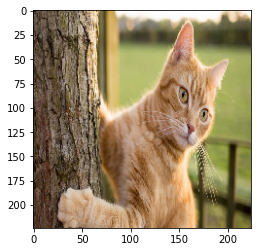

[[0.9868117  0.01318834]]
La classe prédite est cat

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


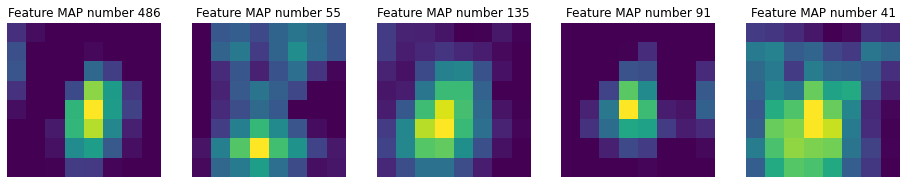

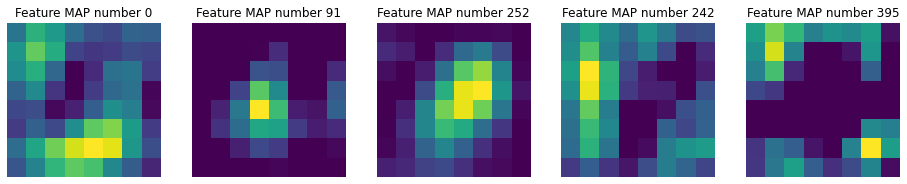

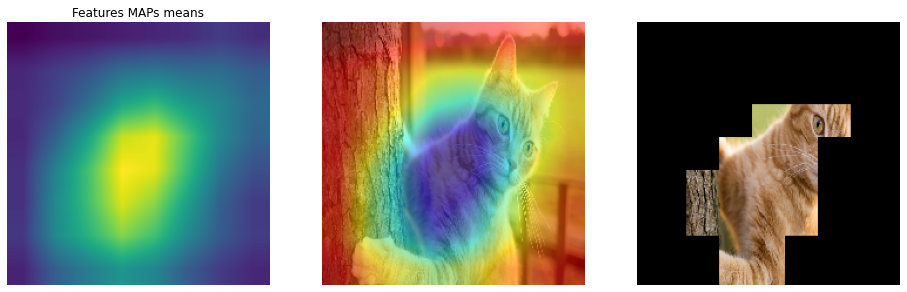

ABLATION-CAM
------------------------------------


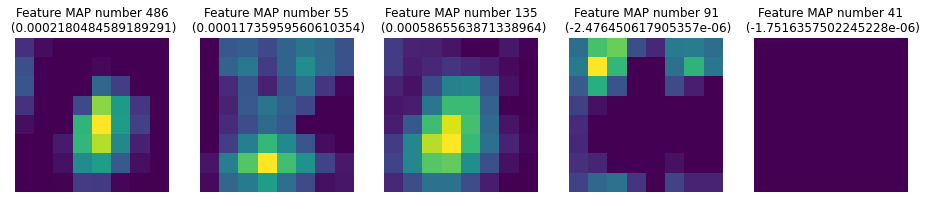

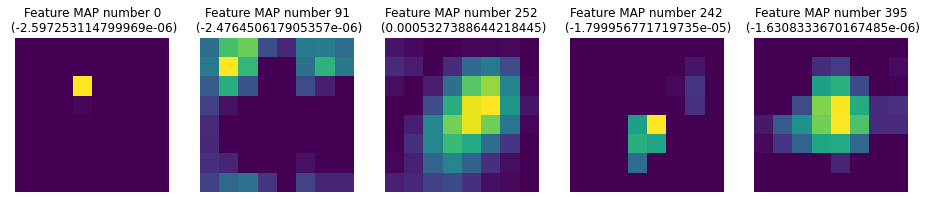

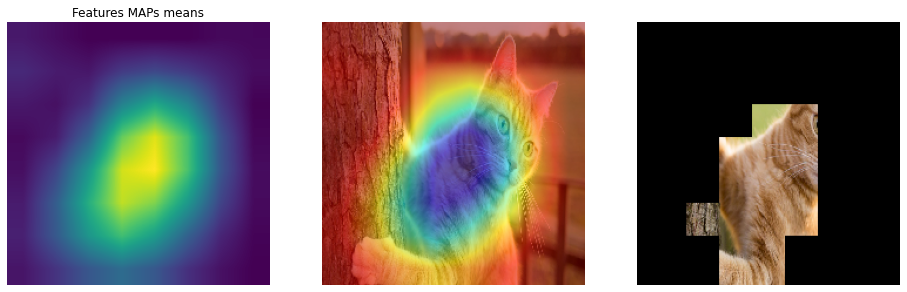

In [6]:
iamge_path = 'test/test4.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19', cat_class_index=preds[0])

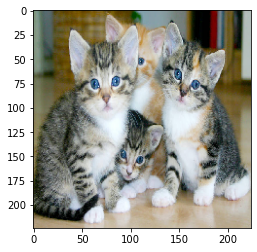

[[0.8792561  0.12074395]]
La classe prédite est cat

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


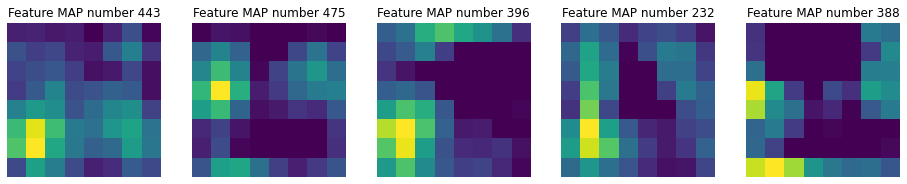

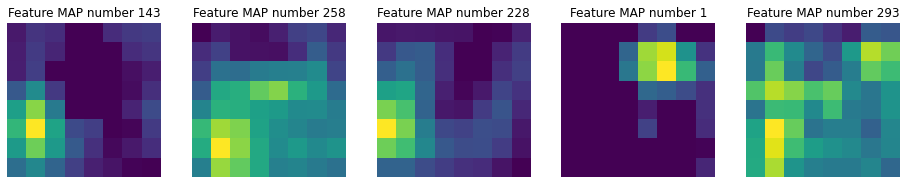

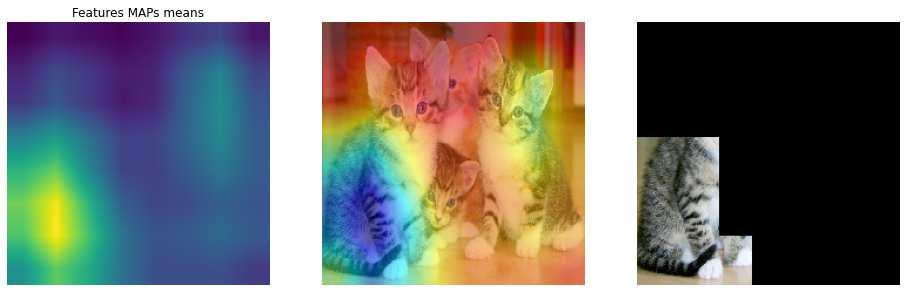

ABLATION-CAM
------------------------------------


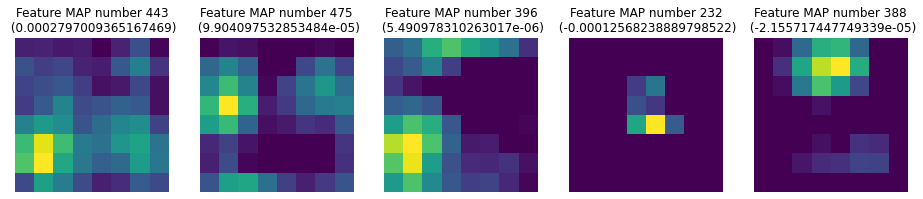

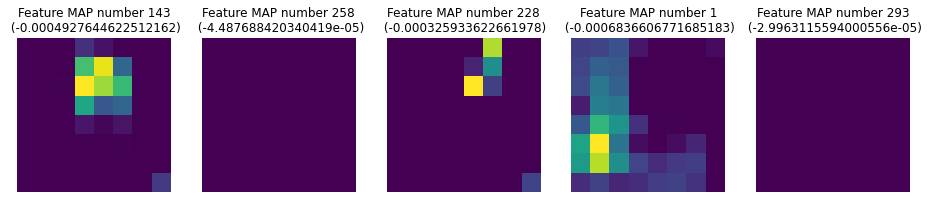

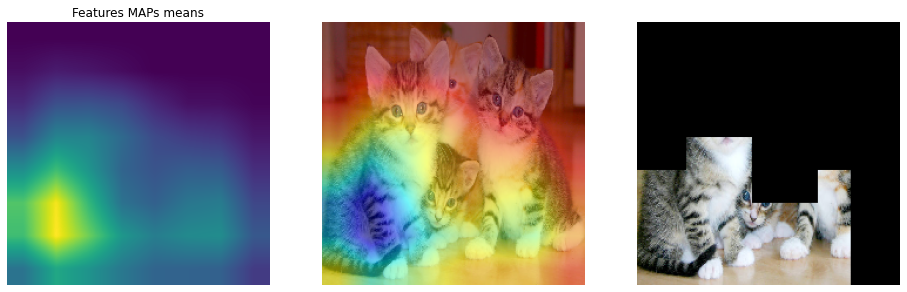

In [7]:
iamge_path = 'test/test3.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19', cat_class_index=preds[0])

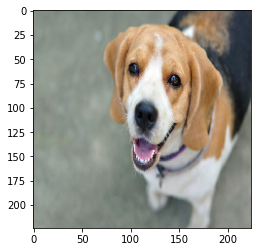

[[7.3874684e-10 1.0000000e+00]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


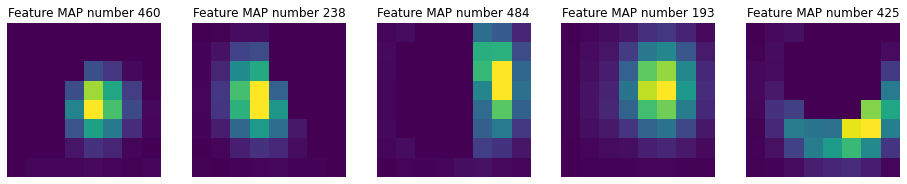

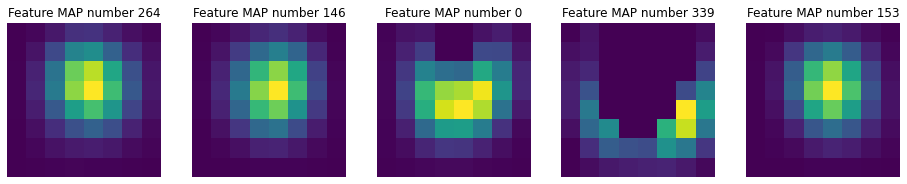

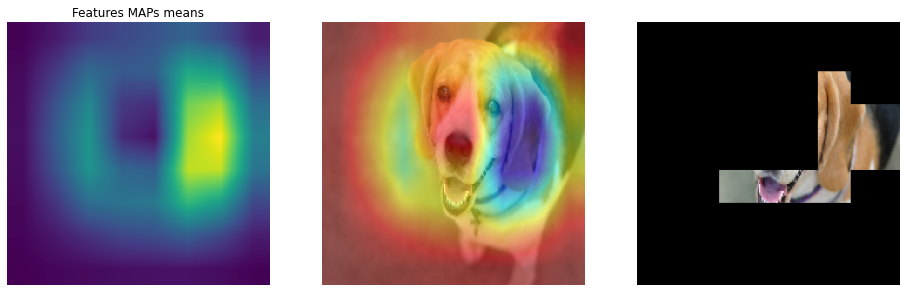

ABLATION-CAM
------------------------------------


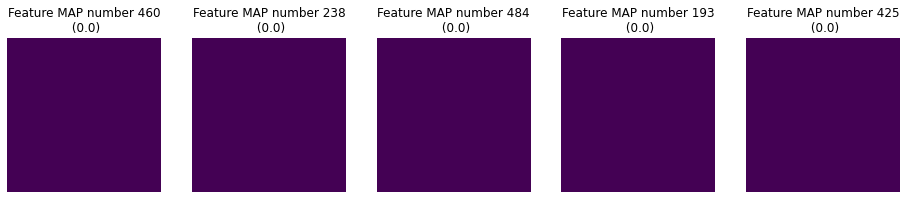

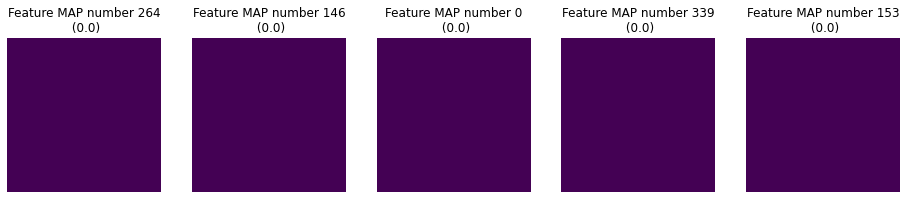

/tmp/ipykernel_1165553/3759214866.py:157: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (ablations_cam - ablations_cam.min()) / (ablations_cam.max() - ablations_cam.min())


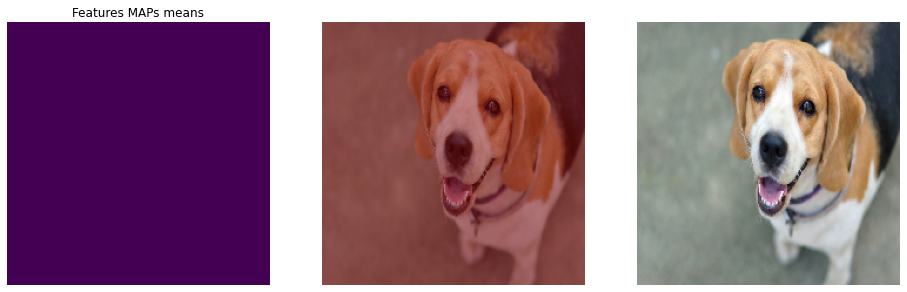

In [8]:
iamge_path = 'test/test2.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19')

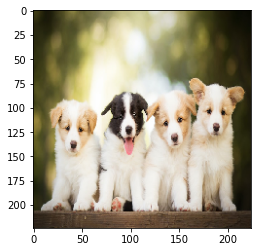

[[0.28210735 0.71789265]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


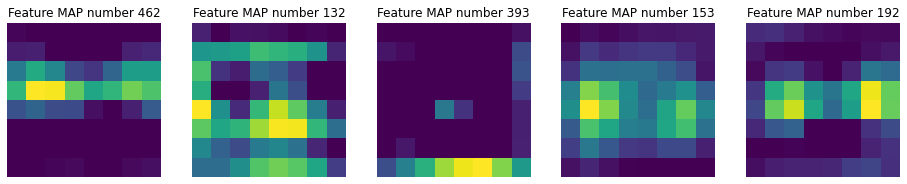

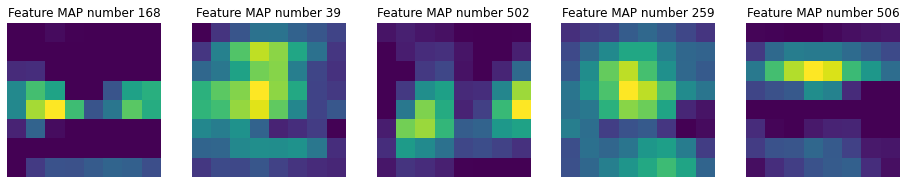

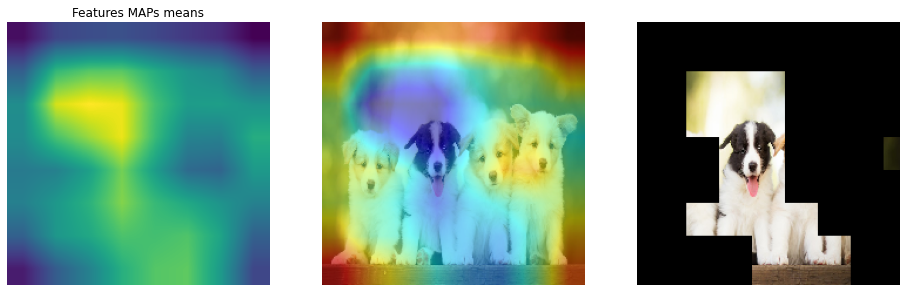

ABLATION-CAM
------------------------------------


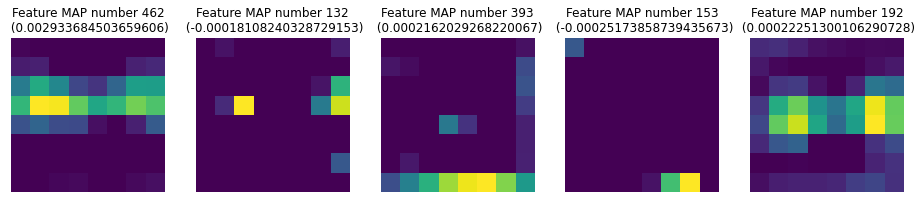

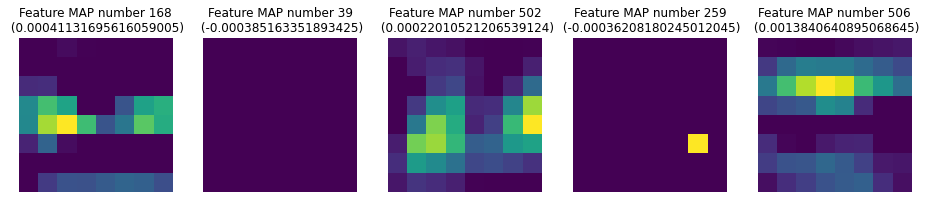

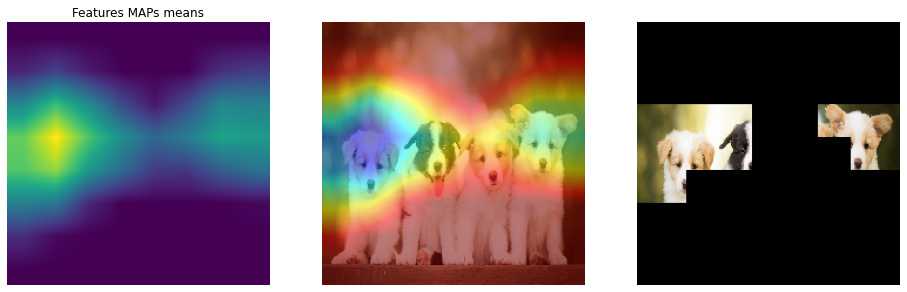

In [9]:
iamge_path = 'test/test1.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19')

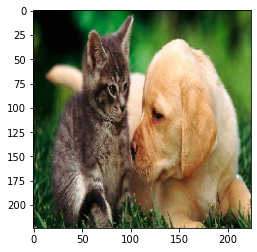

[[0.23751427 0.76248574]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


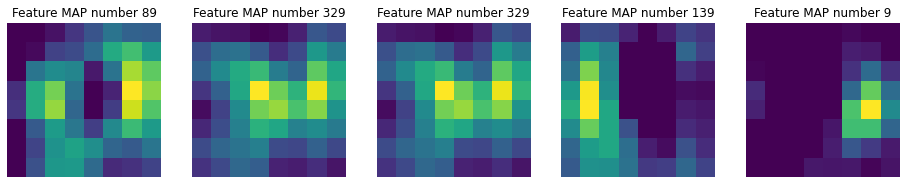

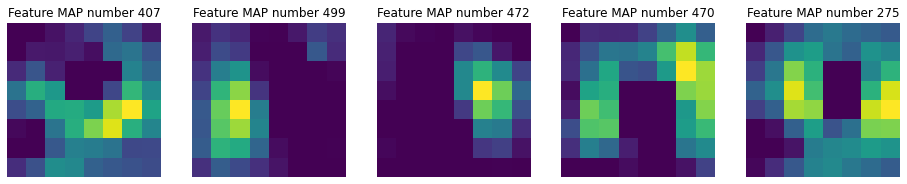

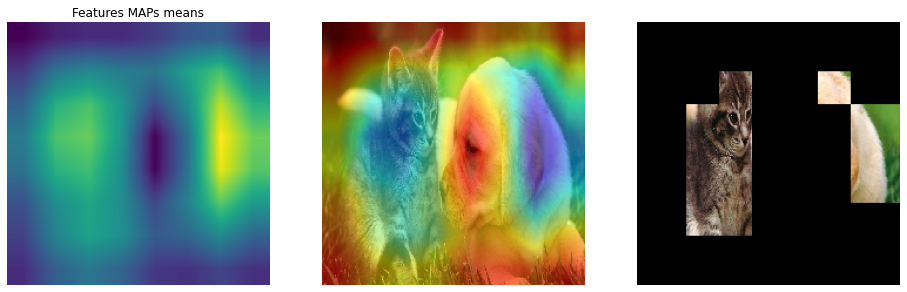

ABLATION-CAM
------------------------------------


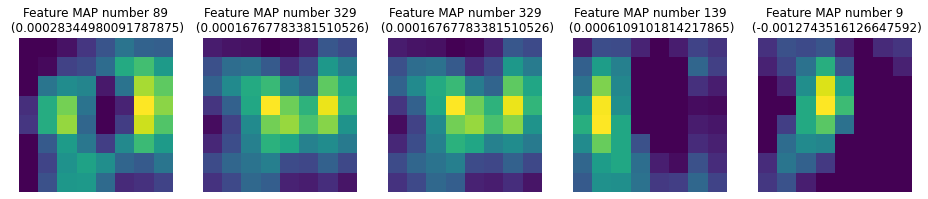

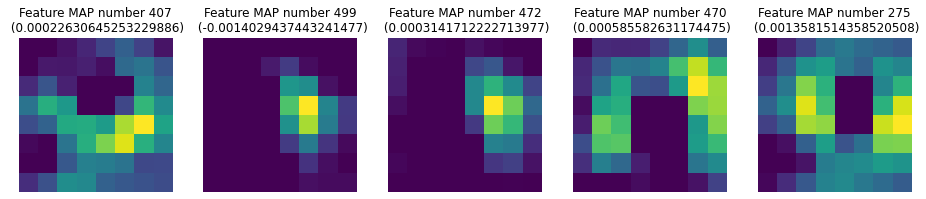

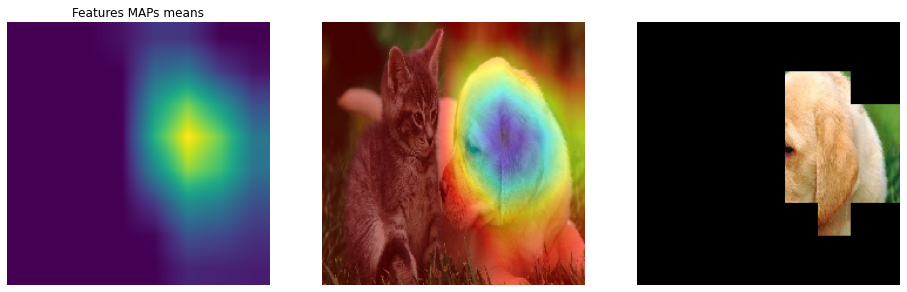

In [10]:
iamge_path = 'test/test5.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19', cat_class_index=preds[0])

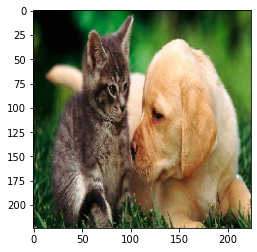

[[0.23751427 0.76248574]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


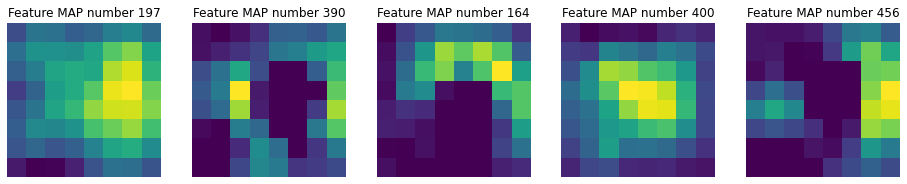

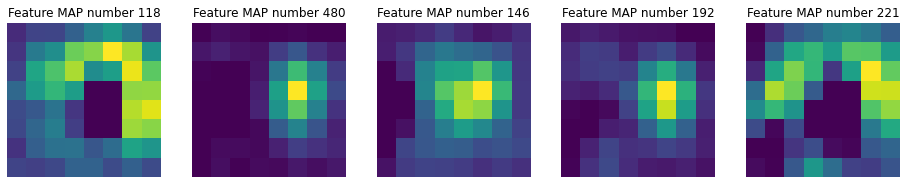

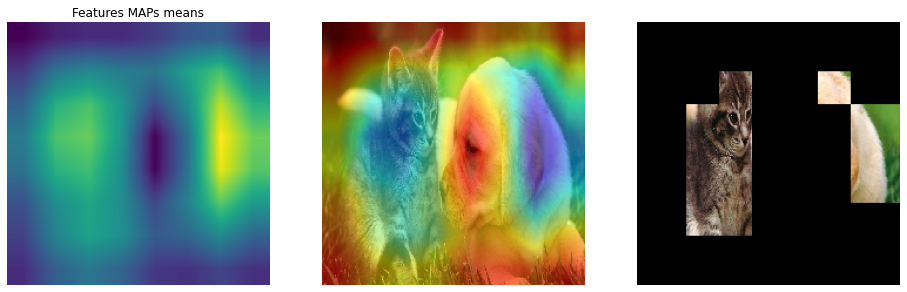

ABLATION-CAM
------------------------------------


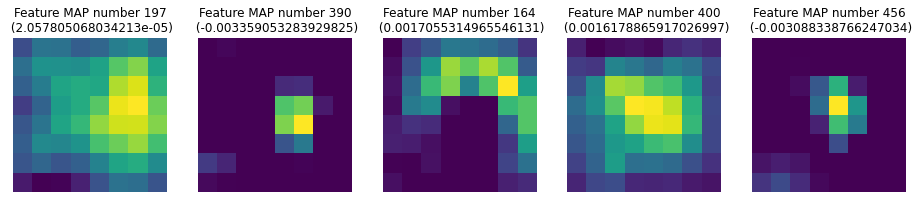

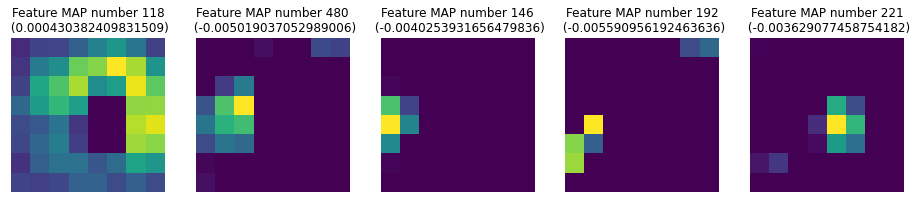

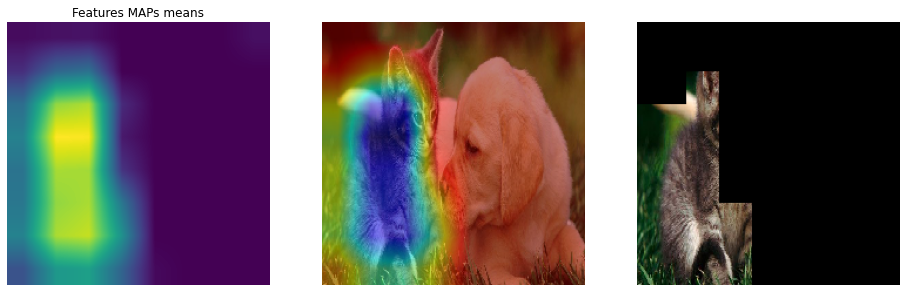

In [11]:
iamge_path = 'test/test5.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19', cat_class_index=0)

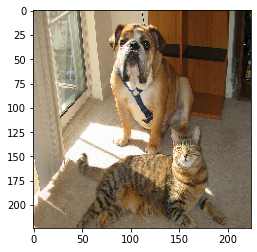

[[0.4472001 0.5528   ]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


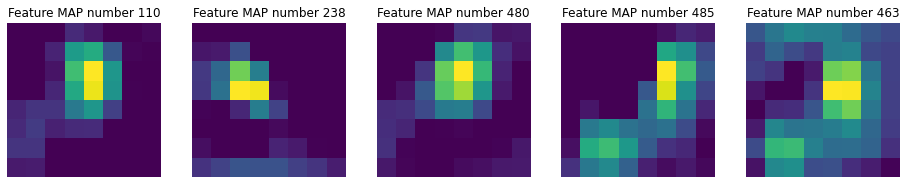

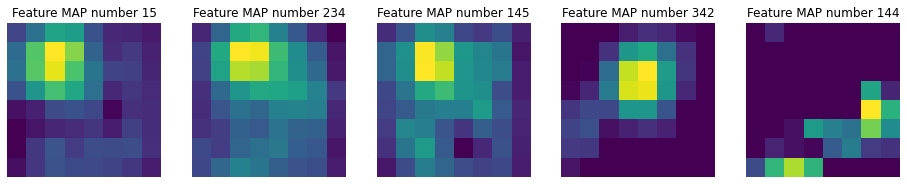

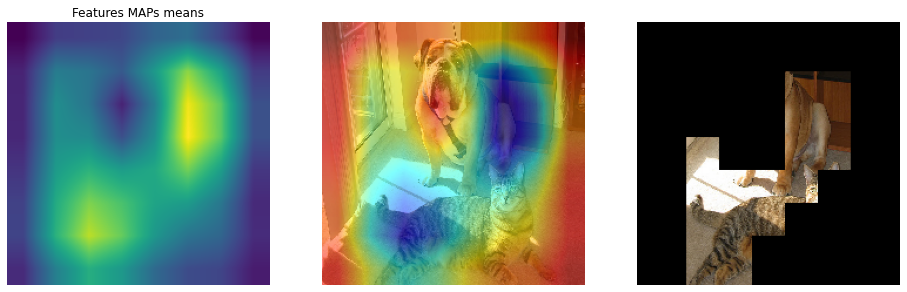

ABLATION-CAM
------------------------------------


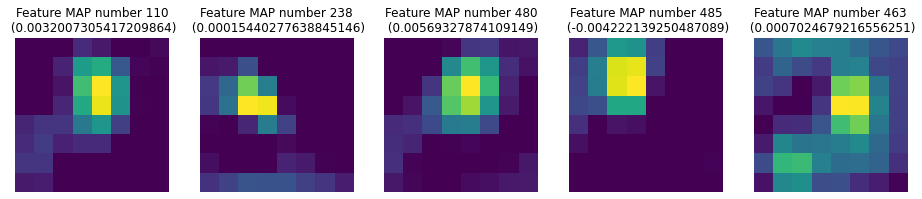

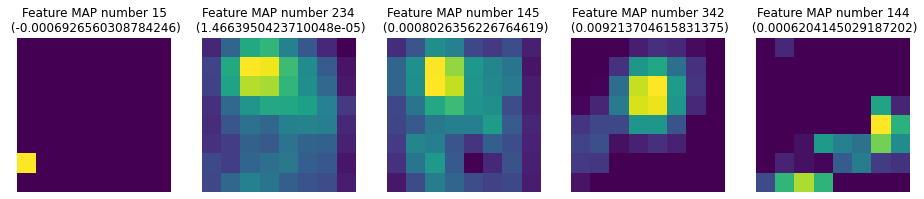

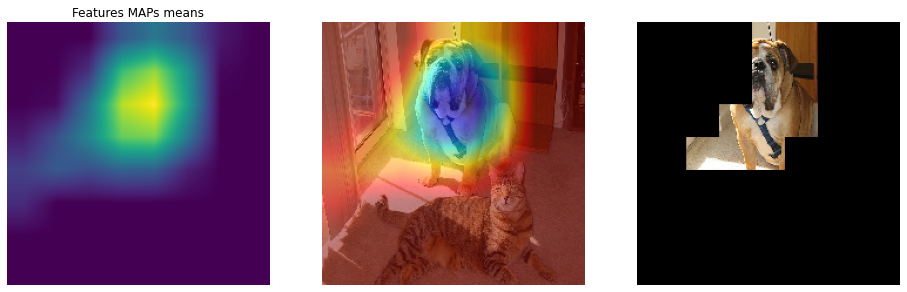

In [13]:
iamge_path = 'test/test7.png'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19')

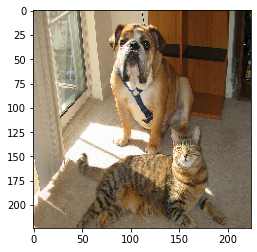

[[0.4472001 0.5528   ]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


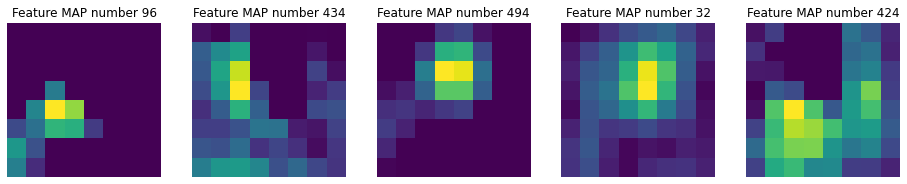

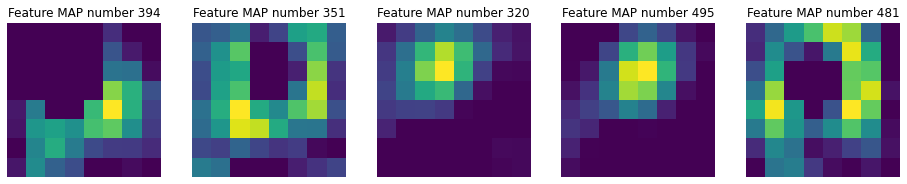

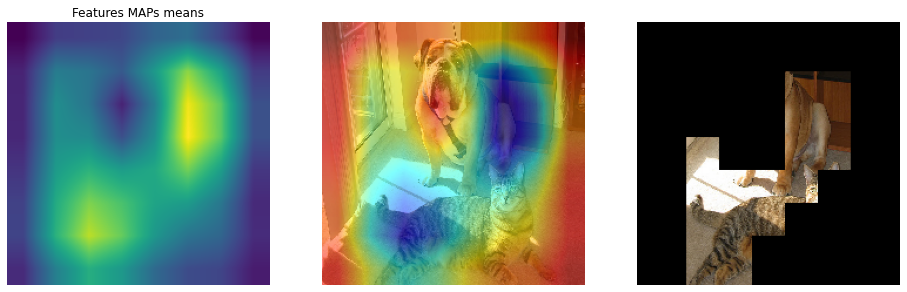

ABLATION-CAM
------------------------------------


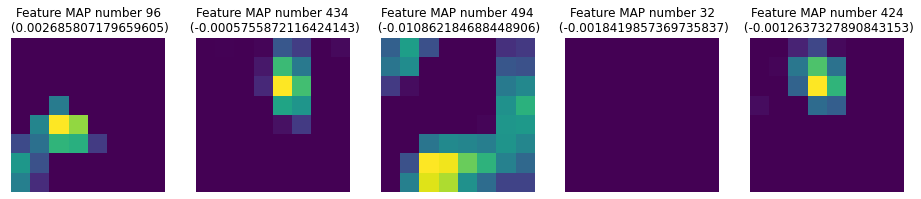

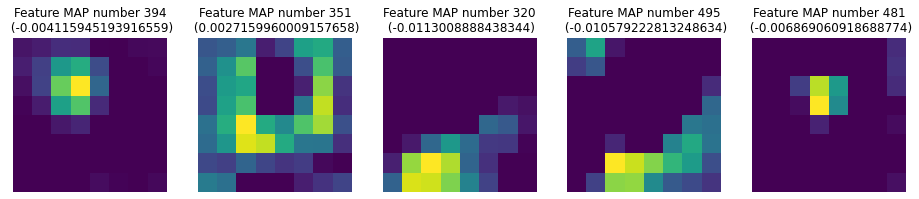

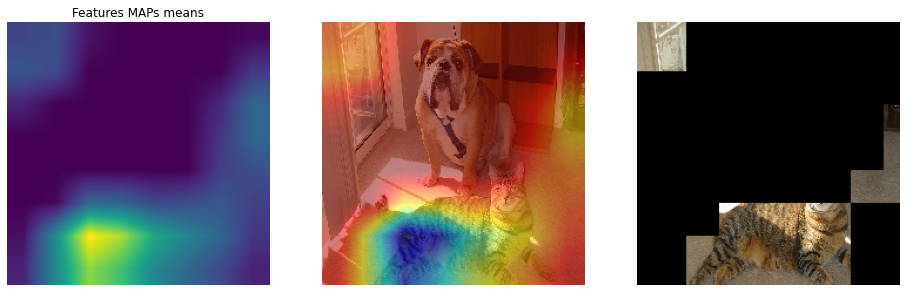

In [14]:
iamge_path = 'test/test7.png'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

ablation_cam(model, img, 'conv2d_19', cat_class_index=0)